<a href="https://colab.research.google.com/github/Solrak97/clasificador_de_sentimientos/blob/main/Prueba_de_concepto_RAVDESS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle wavio pydub keras-metrics
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download uwrfkaggler/ravdess-emotional-speech-audio
! unzip ravdess-emotional-speech-audio.zip

## Bibliotecas necesarias

In [ ]:
import soundfile # to read audio file
import numpy as np
import librosa # to extract speech features
import glob
import os
import pickle # to save model after training

from pydub import AudioSegment

import seaborn as sns
from matplotlib import pyplot as plt


## Extraccion de caracteristicas

In [ ]:
def extract_feature(file_name, **kwargs):
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz") 

    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate

        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
      
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=128).T, axis=0)
            result = np.hstack((result, mfccs))
           
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
           
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
           
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
           
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
           
    return result

## Enums de emociones dentro del dataset RAVDESS

In [ ]:
# we allow only these emotions ( feel free to tune this on your need )
AVAILABLE_EMOTIONS = {
    "neutral",
    "calm",
    "happy",
    "sad",
    "angry",
    "fearful",
    "disgust",
    "surprised"
}

## Transformación del dataset para un estudio más adecuado

### Mapas de categoría


In [ ]:
'''
Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
'''

INT_2_MODALITY = {
    '01' : 'full-AV',
    '02' : 'video-only',
    '03' : 'audio-only'
}

INT_2_VOCAL = {
    '01' : 'speech',
    '02' : 'song'
}

INT_2_EMOTION = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

INT_2_INTENSITY = {
    '01' : 'normal', 
    '02' : 'strong'
}

INT_2_STATEMENT = {
    '01' : '"Kids are talking by the door"',
    '02' : '"Dogs are sitting by the door"'
}

INT_2_REPETITION = {
    '01' : '1st repetition', 
    '02' : '2nd repetition'
}

In [ ]:
import pandas as pd


def load_data():

    _modality = []
    _vocal_channel = []
    _emotions = []
    _intensity = []
    _statement = []
    _repetition = []
    _actor = []
    _features = []

    X, y = [], []

    for file in glob.glob("Actor_*/*.wav"):
            
      file_name=os.path.basename(file)
      
      # El audio viene en estereo para algunas partes
      # Así que se pasa a mono
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
      sound.export(file, format="wav")
  
      name_split = file_name.split("-")
      emotion = INT_2_EMOTION[name_split[2]]

      # Limitación de emociones
      if emotion not in AVAILABLE_EMOTIONS:
        continue
      
      _modality.append(INT_2_MODALITY[name_split[0]])
      _vocal_channel.append(INT_2_VOCAL[name_split[1]])
      _intensity.append(INT_2_INTENSITY[name_split[3]])
      _statement.append(INT_2_STATEMENT[name_split[4]])
      _repetition.append(INT_2_REPETITION[name_split[5]])
      _actor.append(name_split[6])
      _emotions.append(emotion)

      # Extracción de los datos graciosos
      features = extract_feature(file, mfcc=True, 
                                 chroma=True, mel=True, 
                                 contrast=True, tonnetz=True)
      
      _features.append(features)


    data = {
      'Modality' :  _modality,
      'Vocal Channel' : _vocal_channel,
      'Emotion' : _emotions,
      'Intensity' : _intensity,
      'Statement' : _statement,
      'Repetition' : _repetition,
      'Actor_ID' : _actor,
      'Features' : _features
    } 

    df = pd.DataFrame(data)

    return df

## Esta vara es super slow, así que metí los datos en un pkl y los podemos sacar de ahí

In [ ]:
# Va para un pkl porque esto es slooooooow
def save_pkl(data):
    with open('data.pkl', 'wb') as file:
      pickle.dump(data, file)

# Carga desde el pkl
def load_pkl():    
    with open('data.pkl','rb') as file:
      data = pickle.load(file)
    return data

## Carga de datos

In [ ]:
# Carga de datos desde Kaggle
data = load_data()

#save_pkl(data)

# Carga de datos procesados desde pkl
#data = load_pkl()

# Usar eventualmente
#train_test_split(np.array(X), y, test_size=0.3, random_state=42)

data.head()

,Modality,Vocal Channel,Emotion,Intensity,Statement,Repetition,Actor_ID,Features
0,audio-only,speech,happy,strong,"""Dogs are sitting by the door""",2nd repetition,14.wav,"[-486.71234130859375, 31.76954460144043, -27.6..."
1,audio-only,speech,sad,normal,"""Kids are talking by the door""",2nd repetition,14.wav,"[-724.6514282226562, 55.71769714355469, 4.6227..."
2,audio-only,speech,angry,strong,"""Kids are talking by the door""",2nd repetition,14.wav,"[-425.3967590332031, 45.91071701049805, -28.68..."
3,audio-only,speech,surprised,strong,"""Dogs are sitting by the door""",2nd repetition,14.wav,"[-625.5650024414062, 37.601566314697266, -3.69..."
4,audio-only,speech,calm,normal,"""Dogs are sitting by the door""",1st repetition,14.wav,"[-744.2587890625, 37.927268981933594, 0.383281..."


## Informacion relevante

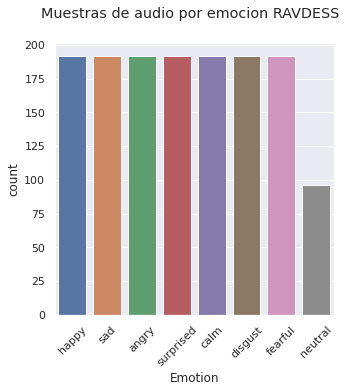

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set()

fig, axes = plt.subplots(1, 1, sharex=True, figsize=(5,5))
fig.suptitle('Muestras de audio por emocion RAVDESS')
chart = sns.countplot(x="Emotion", data=data)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

plt.show()

# Importaciones necesarias para crear los modelos

In [ ]:
import keras
from keras import Sequential
from keras.layers import Dropout, MaxPool1D, Flatten, Dense, ReLU, Input, BatchNormalization, Softmax
from keras.layers.convolutional import Conv1D

# Baseline topology replication

In [ ]:
from keras.layers.advanced_activations import Softmax
def build_baseline():
  model = Sequential()

  # input layer
  model.add(Input(shape=(193, 1)))
  
  # Primer Convolutional layer
  model.add(Conv1D(strides=1, filters=255, kernel_size=5))
  model.add(BatchNormalization())
  model.add(ReLU())

  # Segund Convolutional layer
  model.add(Conv1D(strides=1, filters=128, kernel_size=5))
  model.add(ReLU())
  model.add(Dropout(rate=0.1))
  model.add(BatchNormalization())

  # Capa de Maxpooling
  model.add(MaxPool1D(pool_size=8))

  # 3 capas convolucionales intermedias
  model.add(Conv1D(strides=1, filters=128, kernel_size=5))
  model.add(ReLU())

  model.add(Conv1D(strides=1, filters=128, kernel_size=5))
  model.add(ReLU())

  model.add(Conv1D(strides=1, filters=128, kernel_size=5))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Dropout(rate=0.2))

  # Capa convolucional final
  model.add(Conv1D(strides=1, filters=128, kernel_size=5))
  model.add(Flatten())
  model.add(Dropout(rate=0.2))

  # Capa densa, tiene la misma cantidad de neuronas que de clases a predecir
  model.add(Dense(units=8))
  model.add(BatchNormalization())
  model.add(Softmax())
  
  return model

## Pruebas del baseline model

In [ ]:
baseline_cnn = build_baseline()
baseline_cnn.summary()